# Reprojection Cross Correlation Test

In order to better isolate features for the neural network to read through, the initial data must be engineered in such a way that the correct patterns are analyzed. For image alignment, normally the goal is to optimize the output by looking at the differences in the data as opposed to the actual data itself.

In this notebook, each projection stack will be reconstructed and then reprojected in order to produce a pair of original projections and reprojections for each angle. These corresponding projections will then be cross correlated and this cross correlation data will be def into the neural network.

In [1]:
# Import essential packages
import os
import math
import numpy as np
import matplotlib.pyplot as plt
import tifffile
from tifffile import imsave

# Import tomography and imaging packages
import tomopy
from skimage.transform import rotate, AffineTransform
from skimage import transform as tf
from scipy.fft import fft2, fftshift
from scipy.signal import correlate

# Import neural net packages
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.profiler
from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import DataLoader
from torchinfo import summary

In [2]:
# Checking to ensure environment and cuda are correct
print("Working Environment: {}".format(os.environ['CONDA_DEFAULT_ENV']))
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
print("Cuda Version: {}".format(torch.version.cuda))
print("Cuda Availability: {}".format(torch.cuda.is_available()))

Working Environment: pytorch
Cuda Version: 11.8
Cuda Availability: True


In [3]:
# Loading data, 25 entries of 128 resolution shepp3ds
res = 128
entries = 25
data = []

for i in range(entries):
    data.append(np.load('./shepp{}-{}/shepp{}-{}_{}.npy'.format(res, entries, res, entries, i), 
                        allow_pickle = True))
    
data = np.asarray(data)

(25, 2)
(2,)
(180, 128, 184)
(1, 360)
(180, 128, 184)


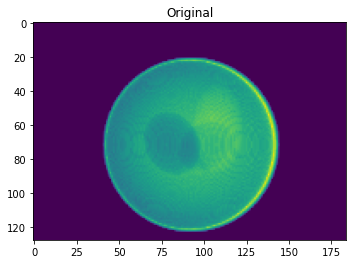

In [4]:
# Checking shape of original data
print(data.shape)
print(data[0].shape)
print(data[0][0][0, 0].shape)
print(data[0][1].shape)

# Getting rid of dimensions added for neural networks in order to plot
test_proj = np.squeeze(data[0][0])
print(test_proj.shape)

# Plot example projection
plt.imshow(test_proj[45, :, :])
plt.title('Original')
plt.show()

In [5]:
def crosscorr_reprojection(data, entries):
    
    ang = tomopy.angles(data[0][0][0, 0].shape[0])
    _rec = 1e-12 * np.ones((data[0][0][0, 0].shape[1], data[0][0][0, 0].shape[2], data[0][0][0, 0].shape[2]))
    data_copy = data.copy()
    out_data = np.zeros((entries, 2), dtype = object)
    
    for i in range (entries):
    
        out_data[i, 0] = np.zeros((1, 1, data[0][0][0, 0].shape[0], data[0][0][0, 0].shape[1] * 2 - 1,
                                      data[0][0][0, 0].shape[2] * 2 - 1))
        out_data[i, 1] = data_copy[i, 1]
        
        rec = tomopy.recon(data_copy[i][0][0, 0], ang, center = None, 
                            algorithm = 'mlem', init_recon = _rec)
        reproj = tomopy.project(rec, ang, center = None, pad = False)
        
        for j in range (data[0][0][0, 0].shape[0]):
            
            out_data[i, 0][0, 0, j] = correlate(data_copy[i][0][0, 0, j], reproj[j], method = 'fft')
        
    return out_data

In [6]:
crosscorr_reproj = crosscorr_reprojection(data.copy(), entries)

print(crosscorr_reproj.shape)
print(crosscorr_reproj[0].shape)
print(crosscorr_reproj[0, 0].shape)
print(crosscorr_reproj[0, 1].shape)

(25, 2)
(2,)
(1, 1, 180, 255, 367)
(1, 360)


In [7]:
# Loading data, 25 entries of 128 resolution shepp3ds
res = 128
entries = 25
data = []

for i in range(entries):
    data.append(np.load('./shepp{}-{}/shepp{}-{}_{}.npy'.format(res, entries, res, entries, i), 
                        allow_pickle = True))
    
data = np.asarray(data)

In [8]:
ang = tomopy.angles(data[0][0][0, 0].shape[0])
data_copy = data.copy()
_rec = 1e-12 * np.ones((data[0][0][0, 0].shape[1], data[0][0][0, 0].shape[2], data[0][0][0, 0].shape[2]))
rec = tomopy.recon(data_copy[1][0][0, 0], ang, center = None, 
                            algorithm = 'gridrec', init_recon = _rec)
reproj = tomopy.project(rec, ang, center = None, pad = False)

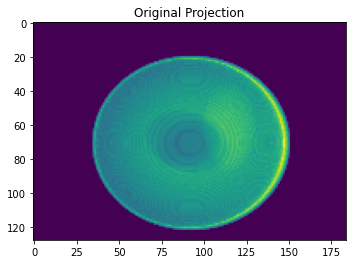

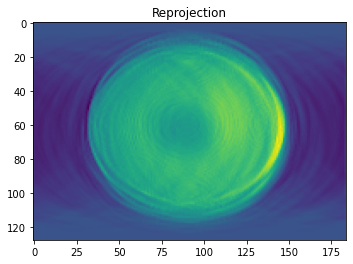

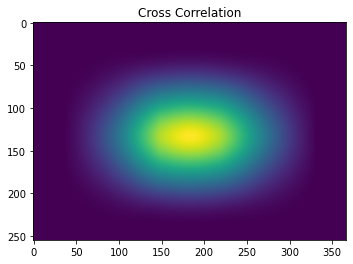

In [9]:
# Plot original projection
plt.imshow(data[0, 0][0, 0, 90, :, :])
plt.title('Original Projection')
plt.show()

# Plot reprojection
plt.imshow(reproj[90, :, :])
plt.title('Reprojection')
plt.show()

# Plot fourier difference
plt.imshow(crosscorr_reproj[0, 0][0, 0, 90, :, :])
plt.title('Cross Correlation')
plt.show()

In [10]:
for i in range(data[0][0][0, 0].shape[0]):
    
    imsave('./correlations/correlation_{}.tiff'.format(i), crosscorr_reproj[0, 0][0, 0, i, :, :].astype(np.float32))